In [90]:
import MetaTrader5 as mt5
import pandas as pd 
import numpy as np 
from scipy.stats import norm 
mt5.initialize()

True

In [91]:
def BlackScholes(r,S,K,T,sigma, tipoOpcao):
    # calcular o preco teórico pelo BS
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # vou calcular apenas para o P (Put)
    tipoOpcao = 'P'
    if tipoOpcao.upper() == "C":
        precoTeoricoOpcao = S * norm.cdf(d1,0,1) - K * np.exp(-r*T) * norm.cdf(d2,0,1)
    else:
        precoTeoricoOpcao = K * np.exp(-r*T) * norm.cdf(-d2,0,1) - S * norm.cdf(-d1,0,1) 
    precoTeoricoOpcao = round(precoTeoricoOpcao,2)
    return precoTeoricoOpcao


In [92]:
def RolarTravaAltaPut(ativosLista, comprei, vendi, diasUteisParaVencer ):
    # [travaFeitaC (comprada) , travaFeitaV (vendida), travaNovaC, travaNovaV]
    # comprei: valor que comprei para montar TA    vendi: valor que vendi
    # vendi - comprei = spread
    travaFeitaC = mt5.symbol_info(ativosLista[0])
    travaFeitaV = mt5.symbol_info(ativosLista[1])
    travaNovaC  = mt5.symbol_info(ativosLista[2])
    travaNovaV  = mt5.symbol_info(ativosLista[3])
    # ativoBase = travaFeitaC.basis
    ativoBaseInfo = mt5.symbol_info(travaFeitaC.basis)

    # gerar matriz
    lin,col = (6,11)
    matriz = [[0 for i in range(col)] for j in range(lin)]
    ###########################################
    # coluna 0 - ativos
    cc = 0 
    matriz[0][cc] = ativoBaseInfo.name
    matriz[1][cc] = travaFeitaC.name 
    matriz[2][cc] = travaFeitaV.name
    matriz[3][cc] = 'dif'
    matriz[4][cc] = '%'
    matriz[5][cc] = 'Ʃ'

    # coluna 1 - strike feitos
    cc +=1 
    matriz[0][cc] = ativoBaseInfo.last
    matriz[1][cc] = travaFeitaC.option_strike
    matriz[2][cc] = travaFeitaV.option_strike
    matriz[3][cc] = travaFeitaV.option_strike - travaFeitaC.option_strike
    matriz[4][cc] = round((travaFeitaV.option_strike / ativoBaseInfo.last -1)*100, 2) 

    # coluna 2 - valores da trava feita
    cc +=1 
    matriz[0][cc] = '*'
    matriz[1][cc] = round(comprei,2)
    matriz[2][cc] = round(vendi,2)
    matriz[3][cc] = round(matriz[1][2] + matriz[2][2], 2)   # spread da TA
    v1 = matriz[3][cc]

    # coluna - valores para desmontar a trava feita
    cc +=1 
    matriz[0][cc] = '*'
    matriz[1][cc] = round(travaFeitaC.bid,2)
    matriz[2][cc] = round(-travaFeitaV.ask,2)
    matriz[3][cc] = round(matriz[1][3] + matriz[2][3], 2)
    v2 = matriz[3][cc]

   # coluna - B&S para desmontar
    cc +=1 
        
    r = 0.02                        # r = taxa de juros    
    S = ativoBaseInfo.last          # S = preço da ação 
    T = diasUteisParaVencer[0]/365               # T = tempo para vencer a opção
    sigma = 0.30                    # sigama = volatilidade
    K =  travaFeitaC.option_strike  # K = strike
    matriz[0][cc] = '*'
    matriz[1][cc] = BlackScholes(r,S,K,T,sigma, 'P')
    K =  travaFeitaV.option_strike  # K = strike
    matriz[2][cc] = -BlackScholes(r,S,K,T,sigma, 'P')
    matriz[3][cc] = round(matriz[1][cc] + matriz[2][cc], 2)

    # COLUNA - LAST - ultimos preços negociados nas opções da trava feita
    cc +=1 
    matriz[0][cc] ='*'
    matriz[1][cc] = travaFeitaC.last
    matriz[2][cc] = -travaFeitaV.last
    matriz[3][cc] = matriz[1][cc] + matriz[2][cc]
    matriz[4][cc] = '' 


    # coluna 4 - ativos novos
    cc +=1 
    matriz[0][cc] = '*'
    matriz[1][cc] = travaNovaC.name
    matriz[2][cc] = travaNovaV.name
    matriz[3][cc] = 'dif'
    matriz[4][cc] = '%'

    
    # coluna 5 - strikes novos
    cc +=1 
    matriz[0][cc] = '*'
    matriz[1][cc] = round(travaNovaC.option_strike,2)
    matriz[2][cc] = round(travaNovaV.option_strike,2)
    matriz[3][cc] = matriz[2][cc] - matriz[1][cc]
    matriz[4][cc] = round((travaFeitaV.option_strike / ativoBaseInfo.last -1)*100, 2) 

    # coluna 6 - valores para montar nova trava
    cc +=1 
    matriz[0][cc] = '*'
    matriz[1][cc] = -travaNovaC.ask
    matriz[2][cc] = travaNovaV.bid
    if matriz[2][cc] == 0:
        fff = input('Entre o valor do Bid ' + travaNovaV.name + ': ')
        matriz[2][cc] = float(fff)
    matriz[3][cc] = matriz[1][cc] + matriz[2][cc]
    v3 = matriz[3][cc]

    # COLUNA - Black & Scholes
    cc +=1 

    r = 0.02                        # r = taxa de juros    
    S = ativoBaseInfo.last          # S = preço da ação 
    T = diasUteisParaVencer[1]/365               # T = tempo para vencer a opção
    sigma = 0.30                    # sigama = volatilidade
    K = travaNovaC.option_strike  # K = strike
    matriz[0][cc] ='.'
    matriz[1][cc] = -BlackScholes(r,S,K,T,sigma, 'P')
    K = travaFeitaV.option_strike  # K = strike
    matriz[2][cc] = BlackScholes(r,S,K,T,sigma, 'P')
    matriz[3][cc] = matriz[1][cc] + matriz[2][cc]
    matriz[4][cc] = '' 

    # COLUNA - LAST - ultimos preços negociados nas opções da trava a fazer
    cc +=1 
    matriz[0][cc] ='*'
    matriz[1][cc] = -travaNovaC.last
    matriz[2][cc] = travaNovaV.last
    matriz[3][cc] = matriz[1][cc] + matriz[2][cc]
    matriz[4][cc] = 'Ʃ' 

    # somatorio
    matriz[5][1] = v1 + v2 + v3 


    columns = ['Ativo', '$$$', '$ Montei', '$ Desmontar' , 'B&S' , '$ last TA feita', 'ativo', 'Strike Novo', 'Montar Novo'  , 'B&S', '$ last TA Nova']
    df = pd.DataFrame(matriz, columns=columns)
    print(df)

    nome_arq = 'RolarTravaAltaPut_' + ativoBaseInfo.name  + '.xlsx'
    df.to_excel(nome_arq)


In [93]:
diasUteisParaVencer = [3,28]   # quantos dias faltam para vencer as opções montadas e a montar, respectivamente
RolarTravaAltaPut(['BBSES220', 'BBSES235', 'BBSET220', 'BBSET235'], -0.15, 0.4, diasUteisParaVencer)

      Ativo    $$$ $ Montei $ Desmontar   B&S $ last TA feita     ativo  \
0     BBSE3  22.90        *           *     *               *         *   
1  BBSES220  22.00    -0.15        0.02  0.02            0.02  BBSET220   
2  BBSES235  23.50      0.4        -0.0 -0.65           -0.61  BBSET235   
3       dif   1.50     0.25        0.02 -0.63           -0.59       dif   
4         %   2.62        0           0     0                         %   
5         Ʃ   0.66        0           0     0               0         0   

  Strike Novo Montar Novo   B&S $ last TA Nova  
0           *           *     .              *  
1        22.0       -0.28 -0.37          -0.26  
2        23.5        0.67  1.08           0.67  
3         1.5        0.39  0.71           0.41  
4        2.62           0                    Ʃ  
5           0           0     0              0  


In [94]:
diasUteisParaVencer = [3,28]   # quantos dias faltam para vencer as opções montadas e a montar, respectivamente
RolarTravaAltaPut(['B3SAS805', 'B3SAS17', 'B3SAT148', 'B3SAT170'], -0.14, 0.7, diasUteisParaVencer)

      Ativo    $$$ $ Montei $ Desmontar   B&S $ last TA feita     ativo  \
0     B3SA3  16.95        *           *     *               *         *   
1  B3SAS805  14.66    -0.14         0.0   0.0            0.01  B3SAT148   
2   B3SAS17  16.66      0.7        -0.1 -0.07           -0.09  B3SAT170   
3       dif   2.00     0.56        -0.1 -0.07           -0.08       dif   
4         %  -1.71        0           0     0                         %   
5         Ʃ   0.64        0           0     0               0         0   

  Strike Novo Montar Novo   B&S $ last TA Nova  
0           *           *     .              *  
1       14.59        -0.2 -0.02          -0.08  
2       16.51        0.38  0.41           0.42  
3        1.92        0.18  0.39           0.34  
4       -1.71           0                    Ʃ  
5           0           0     0              0  


Text(0.5, 1.0, 'BBSET235 23.5')

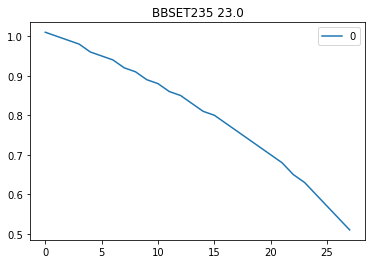

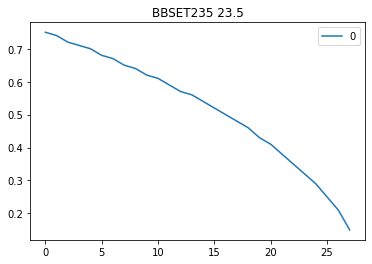

In [110]:
# COLUNA - Black & Scholes
opcao = 'BBSET235'

opcaoInfo = mt5.symbol_info(opcao)
ativoBaseInfo = mt5.symbol_info(opcaoInfo.basis)
r = 0.03
sigma = 0.30
K = opcaoInfo.option_strike

S0 = ativoBaseInfo.last
S1 = 23.00
S2 = 23.50
dias = 28
valores0 = []
valores1 = []
valores2 = []
for d in range(dias, 0, -1):
    T = d/365
    valores0.append(BlackScholes(r,S0,K,T,sigma, 'P'))
    valores1.append(BlackScholes(r,S1,K,T,sigma, 'P'))
    valores2.append(BlackScholes(r,S2,K,T,sigma, 'P'))
df0 = pd.DataFrame(valores0)
df0.plot().set_title(opcao + ' ' + str(S0))
df1 = pd.DataFrame(valores1)
df1.plot().set_title(opcao + ' ' + str(S1))
df2 = pd.DataFrame(valores2)
df2.plot().set_title(opcao + ' ' + str(S2))